# ADM1 Datasets Comparison

This notebook will load the ADM1 (region-level) GeoJSON from **GADM**, **HDX COD-AB**, and **geoBoundaries**, compare feature counts and names, and overlay their boundaries to highlight differences.

In [30]:
import os
import geopandas as gpd

BASE_DIR = 'data/processed'

# Paths to processed ADM1 GeoJSONs
datasets = {
    'GADM': os.path.join(BASE_DIR, 'gadm_adm1.geojson'),
    'HDX': os.path.join(BASE_DIR, 'hdx_adm1.geojson'),
    'geoBoundaries': os.path.join(BASE_DIR, 'geoBoundaries_adm1.geojson')
}

# Quick check
print("Files to be loaded:")
for name, d in datasets.items():
    print(f" - {name}: {d}")

Files to be loaded:
 - GADM: data/processed/gadm_adm1.geojson
 - HDX: data/processed/hdx_adm1.geojson
 - geoBoundaries: data/processed/geoBoundaries_adm1.geojson


## 3. Load ADM1 Datasets & Feature Counts

In [31]:
gdfs = {}
counts = {}
for name, path in datasets.items():
    gdf = gpd.read_file(path)
    gdfs[name] = gdf
    counts[name] = len(gdf)

print("ADM1 region counts by dataset:")
for name, cnt in counts.items():
    print(f" - {name}: {cnt} regions")

ADM1 region counts by dataset:
 - GADM: 14 regions
 - HDX: 14 regions
 - geoBoundaries: 14 regions


In [32]:
# Cell 4 – Print columns of each ADM1 GeoDataFrame
for src, gdf in gdfs.items():
    print(f"{src} columns: {gdf.columns.tolist()}")

GADM columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']
HDX columns: ['ADM0_EN', 'ADM0_RU', 'ADM0_UZ', 'ADM0ALT1EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_RU', 'ADM1_UZ', 'ADM1TYPE_E', 'ADM1TYPE_R', 'ADM1TYPE_U', 'ADM1_PCODE', 'geometry']
geoBoundaries columns: ['Name', 'Level', 'ISO_Code', 'geometry']


In [60]:
import json
import pandas as pd
from difflib import get_close_matches

# 1. Load properties (no shapely needed)
paths = {
    'GADM':          'data/processed/gadm_adm1.geojson',
    'HDX':           'data/processed/hdx_adm1.geojson',
    'geoBoundaries': 'data/processed/geoBoundaries_adm1.geojson'
}
raw = {src: json.load(open(path))['features'] for src, path in paths.items()}

# 2. Extract canonical names WITH suffix
def extract(src):
    out = set()
    for feat in raw[src]:
        p = feat['properties']
        if src == 'GADM':
            t = p.get('ENGTYPE_1','').strip()
            variants = [p.get('NAME_1','')] + str(p.get('VARNAME_1','')).split('|')
            for v in variants:
                if (v:=v.strip()):
                    out.add(f"{v} {t}")
        elif src == 'HDX':
            rawt = p.get('ADM1TYPE_E','').lower()
            t = 'Region' if 'province' in rawt else 'City'
            e = p.get('ADM1_EN','').strip()
            if e: out.add(f"{e} {t}")
        else:  # geoBoundaries
            if (n:=p.get('Name','').strip()):
                out.add(n)
    return out

canon_sets = {src: extract(src) for src in paths}

# 3. Fuzzy cluster case-insensitive
all_names = sorted(set().union(*canon_sets.values()))
lc = {}
for n in all_names:
    lc.setdefault(n.lower(), []).append(n)

clusters = {}
seen = set()
for key in sorted(lc):
    if key in seen: continue
    m = get_close_matches(key, lc.keys(), n=5, cutoff=0.8)
    for k2 in m: seen.add(k2)
    clusters[key] = sorted(sum((lc[k2] for k2 in m), []))

# 4. Manual overrides — you can key by lowercase cluster key OR exact original!
manual_map = {
    'buxoro region':       'Bukhara Region',
    "Mawarranahr Region": "Bukhara Region",
    'dzhizak region':      'Jizzakh Region',
    'jizzakh region':      'Jizzakh Region',

    'Tashkent':     'Tashkent City',
    'toshkent shahri city':'Tashkent City',
    'tashkent city city':  'Tashkent City',
    'tashkent city':       'Tashkent City',

    'Taschkent Region': 'Tashkent Region',
    
    'Qoraqalpog`Iston Autononous Region': 'Karakalpakstan Autononous Region',
    'Republic Of Karakalpakstan': 'Karakalpakstan Autononous Region',

    'Kashka Region': "Qashqadaryo Region",
    "Kashka-Dar'Ya Region": "Qashqadaryo Region",

    "Na Region": "Namangan Region",

    "Sirdaryo Region": "Sirdarya Region",
    "Syrdarya Region": "Sirdarya Region",
}

# 5. Build final_map original→final
final_map = {}
for rep, members in clusters.items():
    # lookup by rep key (lowercase) or by title-cased rep
    final = manual_map.get(rep, 
            manual_map.get(rep.title(), rep.title()))
    for m in members:
        # allow manual override per original too
        final_map[m] = manual_map.get(m, final)

# 7. Normalize sets & show table
norm = {src: { final_map.get(n,n) for n in canon_sets[src] }
        for src in canon_sets}
all_final = sorted(set().union(*norm.values()))
df = pd.DataFrame(index=all_final)
for src in norm:
    df[src] = df.index.isin(norm[src])
df['In_All'] = df.all(axis=1)

df  # display in notebook

,GADM,HDX,geoBoundaries,In_All
Andijan Region,True,True,True,True
Bukhara Region,True,True,True,True
Farg'Ona Region,True,True,True,True
Jizzakh Region,True,True,True,True
Karakalpakstan Autononous Region,True,True,True,True
Khorazm Region,True,True,True,True
Namangan Region,True,True,True,True
Qashqadaryo Region,True,True,True,True
Samarkand Region,True,True,True,True
Sirdarya Region,True,True,True,True


source,GADM,HDX,geoBoundaries,mean_area,min_area,max_area,range_pct
canonical,,,,,,,
Khorazm Region,7366.526506,5339.131770,6907.627584,6537.761954,5339.131770,7366.526506,31.010532
Samarkand Region,14343.866635,16585.971854,16553.094095,15827.644194,14343.866635,16585.971854,14.165754
Sirdarya Region,4893.316442,4671.188277,4351.744758,4638.749826,4351.744758,4893.316442,11.674949
Andijan Region,4501.181307,4358.302038,4226.759980,4362.081108,4226.759980,4501.181307,6.291064
Namangan Region,60028.422432,61787.390739,58777.937229,60197.916800,58777.937229,61787.390739,4.999265
Tashkent City,327.749968,343.488077,337.059966,336.099337,327.749968,343.488077,4.682577
Bukhara Region,40600.433164,38783.880872,39664.498469,39682.937502,38783.880872,40600.433164,4.577666
Farg'Ona Region,6702.738320,6984.610994,6731.675512,6806.341609,6702.738320,6984.610994,4.141324
Qashqadaryo Region,28149.503531,28016.575323,28785.774514,28317.284456,28016.575323,28785.774514,2.716359


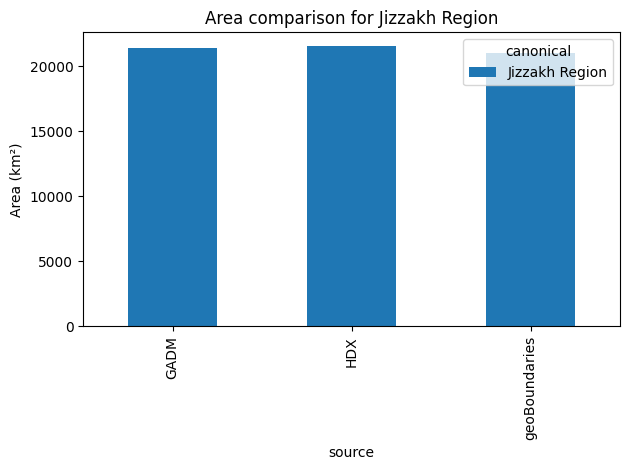

In [64]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# 1. Load full GeoDataFrames (reprojected to equal‐area)
def load_gdf(path):
    return gpd.read_file(path).to_crs(epsg=32642)

gdfs = {
    'GADM':          load_gdf('data/processed/gadm_adm1.geojson'),
    'HDX':           load_gdf('data/processed/hdx_adm1.geojson'),
    'geoBoundaries': load_gdf('data/processed/geoBoundaries_adm1.geojson')
}

# 2. Attach canonical name and compute area_km2
dfs = []
for src, gdf in gdfs.items():
    # build original‐name list for mapping
    if src == 'GADM':
        origs = [f"{r['NAME_1']} {r['ENGTYPE_1']}" for _, r in gdf.iterrows()]
    elif src == 'HDX':
        origs = [f"{r['ADM1_EN']} {'Region' if 'province' in r['ADM1TYPE_E'].lower() else 'City'}"
                 for _, r in gdf.iterrows()]
    else:  # geoBoundaries
        origs = list(gdf['Name'].str.strip())
    # map to your final canonical names (from final_map)
    canons = [final_map.get(o, o) for o in origs]
    df = gdf.copy()
    df['canonical'] = canons
    df['area_km2'] = df.geometry.area / 1e6
    df['source'] = src
    dfs.append(df[['canonical','area_km2','source']])

area_df = pd.concat(dfs, ignore_index=True)

# 3. Aggregate in case of duplicates, then pivot
agg = area_df.groupby(['canonical','source'], as_index=False)['area_km2'].mean()
area_pivot = agg.pivot(index='canonical', columns='source', values='area_km2')

# 4. Compute summary stats
area_pivot['mean_area'] = area_pivot.mean(axis=1)
area_pivot['min_area']  = area_pivot.min(axis=1)
area_pivot['max_area']  = area_pivot.max(axis=1)
area_pivot['range_pct'] = (area_pivot['max_area'] - area_pivot['min_area']) / area_pivot['mean_area'] * 100

# 5. Show the top 10 regions by area discrepancy
top_diff = area_pivot.sort_values('range_pct', ascending=False).head(10)
display(top_diff)

# 6. Example plot for one region
region = 'Jizzakh Region'
top_diff.loc[[region], ['GADM','HDX','geoBoundaries']].T.plot(
    kind='bar',
    title=f"Area comparison for {region}",
    ylabel="Area (km²)"
)
plt.tight_layout()
plt.show()

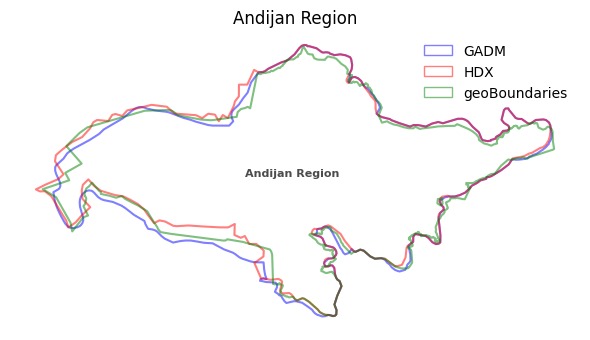

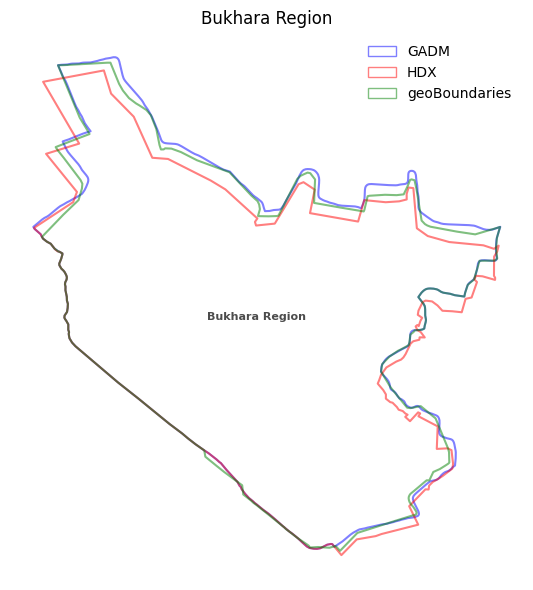

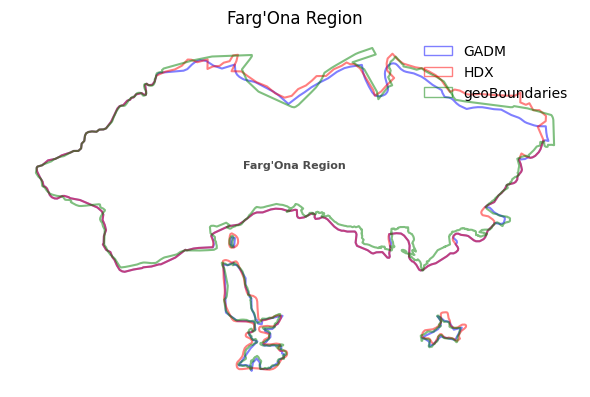

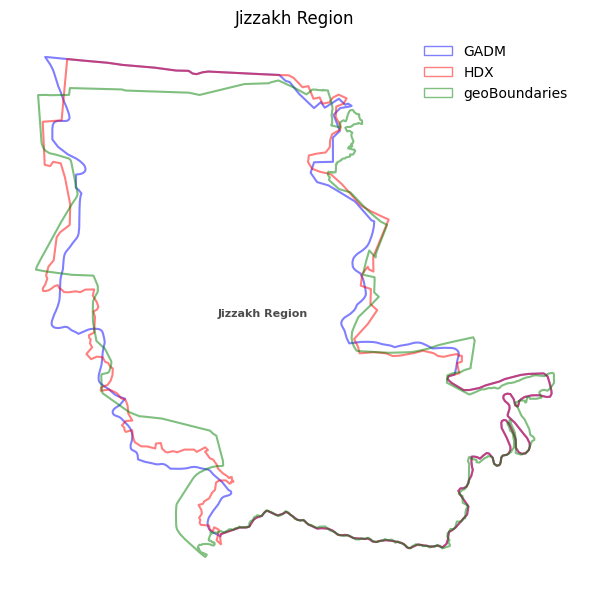

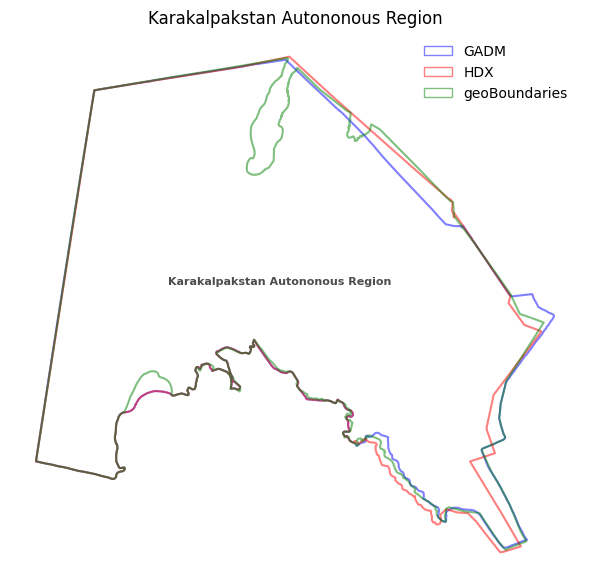

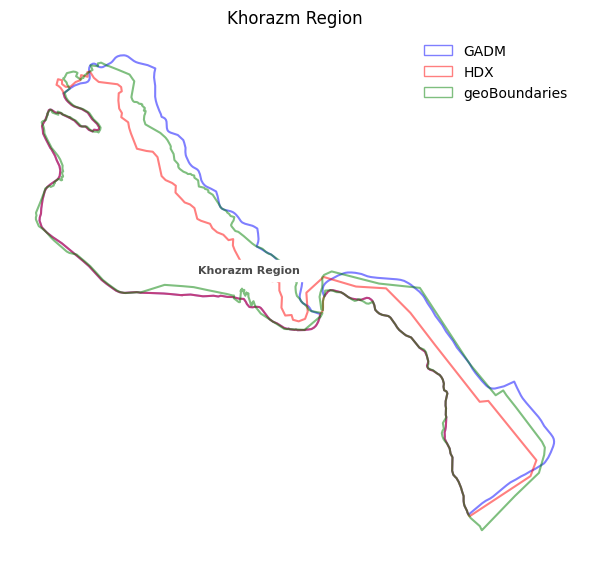

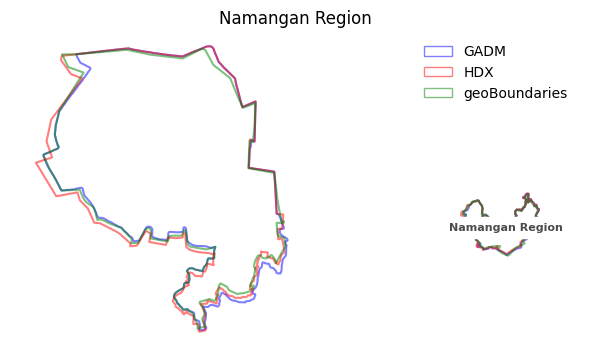

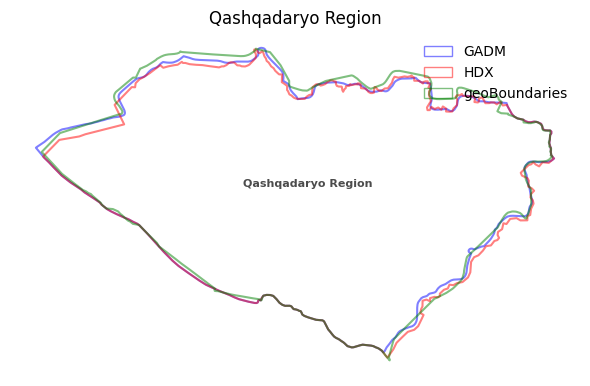

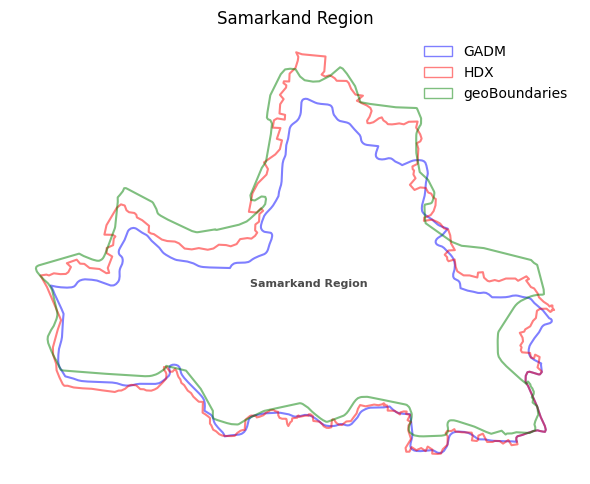

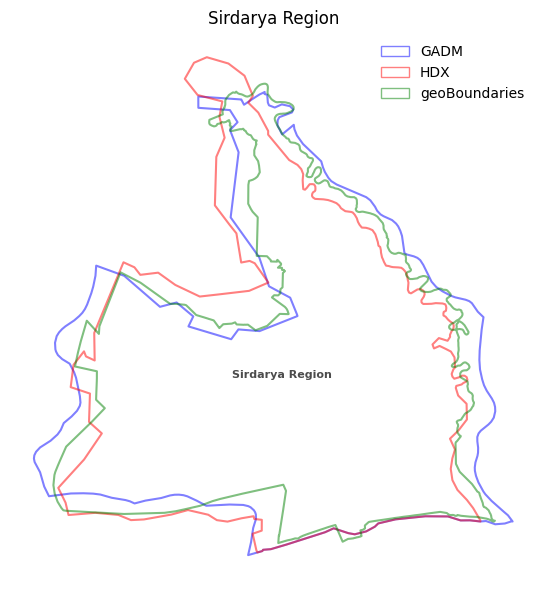

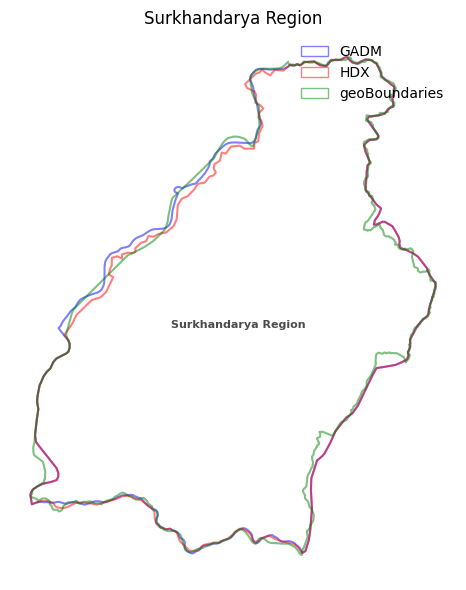

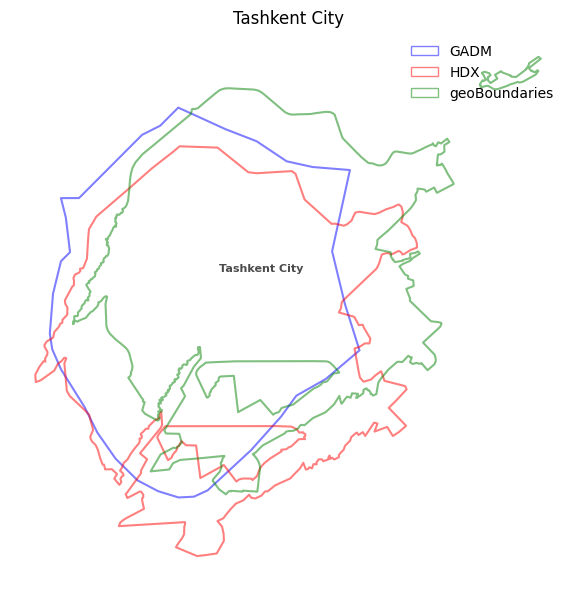

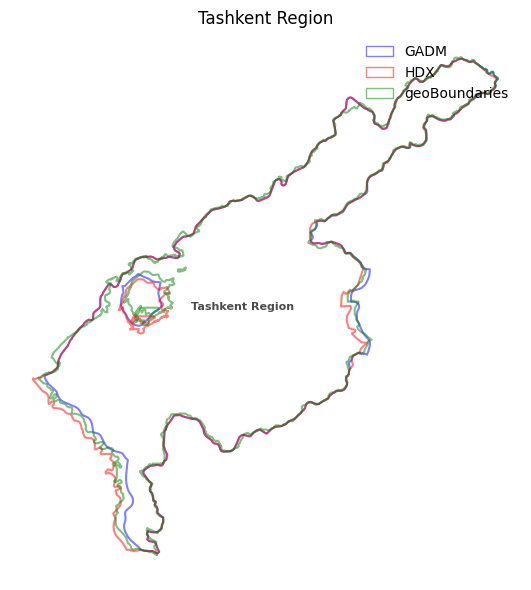

In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. (Re)load and prepare GeoDataFrames with canonical names and equal‐area CRS
def load_and_prepare(path, src):
    gdf = gpd.read_file(path).to_crs(epsg=32642)
    # build the original‐name list
    if src == 'GADM':
        names = [f"{r['NAME_1']} {r['ENGTYPE_1']}" for _,r in gdf.iterrows()]
    elif src == 'HDX':
        names = [f"{r['ADM1_EN']} {'Region' if 'province' in r['ADM1TYPE_E'].lower() else 'City'}"
                 for _,r in gdf.iterrows()]
    else:
        names = list(gdf['Name'].str.strip())
    # map to final canonical
    gdf['canonical'] = [ final_map.get(n, n) for n in names ]
    return gdf

paths = {
    'GADM':          'data/processed/gadm_adm1.geojson',
    'HDX':           'data/processed/hdx_adm1.geojson',
    'geoBoundaries': 'data/processed/geoBoundaries_adm1.geojson'
}

gdfs_prepped = {src: load_and_prepare(path, src) for src,path in paths.items()}

colors = {'GADM':'blue', 'HDX':'red', 'geoBoundaries':'green'}

# Build proxy patches for the legend
legend_patches = [
    Patch(edgecolor=col, facecolor='none', label=src, alpha=0.5)
    for src, col in colors.items()
]

# List of all canonical region names
regions = sorted({row['canonical'] 
                  for gdf in gdfs_prepped.values() 
                  for _, row in gdf.iterrows()})

for region in regions:
    fig, ax = plt.subplots(figsize=(6,6))
    
    for src, gdf in gdfs_prepped.items():
        subset = gdf[gdf['canonical'] == region]
        if subset.empty:
            continue
        
        subset.plot(
            ax=ax,
            facecolor='none',
            edgecolor=colors[src],
            linewidth=1.5,
            alpha=0.5
        )
        centroid = subset.geometry.centroid.iloc[0]
    
    # Label at centroid
    ax.text(
        centroid.x, centroid.y, region,
        fontsize=8, fontweight='bold',
        ha='center', va='center',
        backgroundcolor='white', alpha=0.7
    )
    
    ax.set_title(region)
    ax.set_axis_off()
    # Use our proxy handles
    ax.legend(handles=legend_patches, frameon=False)
    
    plt.tight_layout()
    plt.show()